# Efficient training of neural networks

In the previous notebook, we outlined how neural networks can solve a large variety of tasks. Specifically, we demonstrated that neural networks can be used for image classification and for predicting complex biological processes, such as the conductance of nerve membranes. The main reason for this verstility of neural networks is two-fold: 
1. neural networks are universal function approximators, meaning they can learn any function from data; and 
2. surprisingly many tasks can be approximated as input-output relationships, i.e. functions. 

For example, we saw that digit classification can be achieved by learning a probability density function, $p(y | x)$, where $x$ denotes the pixels in the image, and $y$ denotes the digit. In this notebook, we dive deeper into some of the challenges of learning functions from data -- challenges that are important to understand when modelling language with neural networks.

**Learning outcomes:**

1. An intuitive understanding of architectural choices for neural networks
2. An understanding of the limitations of neural networks when learning functions from data
3. The value of prior knowledge for more efficient learning and better generalisation

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import kai

## 1 Using neural networks for language processing

The universal function approximation theorem states that multi-layer perceptrons (MLPs) can approximate any function, provided they have sufficiently many artificial neurons. This makes it possible to learn any function from data using neural networks. At this point, you might start to wonder what all of this has to do with natural language processing and large language models... After all, language seems to be quite different from simple input-output relationships, making it hard to imagine how the universality of neural networks helps with processing language.

But how different is language from an input-output relationship really? If we think, for example, about chatbots like our very own Equinor AIChat, typical interactions with the chatbot often take the form of questions (inputs) and answers (outputs): We ask a question or make a statement; and the chatpot replies. Hmm, so perhaps some elements of language can be interpreted as an input-output relationship after all!

That's exciting! Let us try to develop a neural network that can answer questions.

### Task 1: Brainstorm how you could use an MLP to answer questions

Assume for now that we have a fixed number of questions that can be asked and that also the number of answers to each question is fixed. What could the inputs to the network represent? What would the outputs be?

You can document your thoughts here:

The challenge of processing language using neural network is that neural networks can only process and output numerical values. We therefore need to map questions and answers to numerical values. A naïve approach to achieve this for a fixed number of questions and answers is to enumerate the questions and the answers. The question ID can then be used as an input to the neural network and the output of the neural network would be either the corresponding answer ID, or, if we want to capture the possibility of multiple answers, a probability mass function over the answer IDs. 

### Task 2: What are the limitations of the Q&A MLP?

After making an initial attempt to define suitable inputs and outputs to the Q&A neural network, have a look at some example questions and answers below. Do you foresee any challenges with answering those questions with your approach? Think especially about how well your model might answer questions that it has not seen before, or even how it might answer questions that only use a slightly different wording than those in the datatset. 

*Tipp:* If you struggle to see the limitations of your Q&A neural network, let us simply try simply it out and see how well it does! Create a code cell below this one and use the Q&A data to train an MLP. You can copy the neural network definition and the training script from the previous notebook. For simplicity, you could just focus on the first 50 questions and answers in the dataset and use the ``nn.CrossEntropyLoss()`` as an objective for the training. Remember to split your dataset into a training and into a test dataset to test your model on unseen questions. How well can your model answer the questions?

In [2]:
data = kai.get_qa_datatset()

print(data[0])
print('')
print(data[30])
print('')
print(data[42])

{'qId': 'wqr000001', 'answers': ['Padmé Amidala'], 'question': 'what character did natalie portman play in star wars?'}

{'qId': 'wqr000567', 'answers': ['Apollo 13', 'A Beautiful Mind', 'Curious George', 'Happy Days', 'Cocoon', 'From the Earth to the Moon'], 'question': 'what movies did ron howard do?'}

{'qId': 'wqr000718', 'answers': ['Alan Ruck'], 'question': "who plays ferris bueller's best friend?"}


Ok, it's obvious that the Equinor AIChat does not use our simple Q&A neural network approach! While it is possible to enumerate questions and answers and to train a neural network to remember the mapping between questions and answers, it does not actually allow the neural network to answer any questions that are not identical to the training questions. In fact, by enumerating questions and answers, we abstract away any logic or knowledge that a human might be able to infer from the question-answer pairs, making it impossible to answer any new questions, even if the answers are contained in the training data.

For example, if the training data contained the question-answer pairs:

- Q: How long have Alice and Bob been living together? A: Alice and Bob have been living together for 10 years.
- Q: Who is Bob's neighbour? A: Bob's neighbour is Anders Opedal.

A human can infer that Alice's neighbour is Ander Opedal. But if we asked our simple Q&A neural network "Who is Alice's neighbour?", it would not be able to answer the question. In contrast, modern large language models *can* make similar inferences and answer many questions that they have not seen before. So we seem to be missing an important component of developing neural networks to make natural language processing work.

Note that, in principle, our Q&A neural network *can* answer any questions provided they are contained in the training data. It simply cannot make any inferences or generalise beyond the training questions in its current formulation. I.e. the universality of neural network approximations is not enough to solve natural language processing in practice.

## 2 Universal, but not generalisable

The challenges of using MLPs for learning function approximations that generalise beyond the training data are not unique to language processing. In fact, one of the first approaches that improved the generalisability of neural networks came from image classification. This advancement ultimately led to the development of the LLM neural networks that we are using today. We will therefore focus in this notebook on understanding this approach.

To begin, let us revisit the MNIST image classification task that we have worked on in the previous notebook. Below we have defined the MLP for the image classification. The only new element to the previous notebook is that we have slighly increased the size of the images by padding the space around the digits (see cell below). 

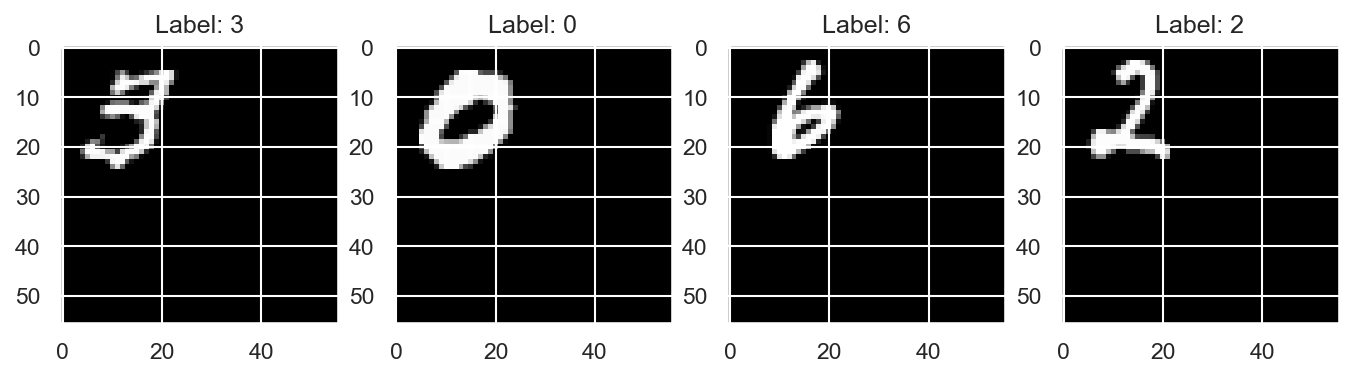

In [2]:
# Load data
train_loader, test_loader1, test_loader2 = kai.get_modified_mnist_data()

# Get a batch of images and labels
images, labels = next(iter(train_loader))

kai.plot_images(images, labels)

### Task 3: Train the neural network on the new dataset

In [3]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set up training
input_size = 784 * 4  # Need to increase input size because images are bigger
num_classes = 10
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Network
model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device)

# Loss and Optimizer
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
kai.train_mnist_model(
    num_epochs, model, objective, optimizer, train_loader, device)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


### Task 4: Check that the accuracy on the training data is still the same
You should get an accuracy of >95%.

In [5]:
print('Accuracy on training data:')
kai.check_accuracy(train_loader, model, device)

Accuracy on training data:
Got 58393/60000 with accuracy  97.32


Amazing! The padding of the images had no effect on the training accuracy -- and why would it?!? The digits in the images remain the same, whether there is black space around them or not. So let's very that the accuracy also is still the same on the test images (which we haven't used for the training).

### Task 5: Evaluate the accuracy of the model on the two test datasets
The test datasets are defined by ``test_loader1`` and by ``test_loader2``.

In [6]:
# TODO: Check the accuracy of the model on the test datasets
print('Accuracy on test data 1:')
kai.check_accuracy(test_loader1, model, device)

print('Accuracy on test data 2:')
kai.check_accuracy(test_loader2, model, device)

Accuracy on test data 1:
Got 9642/10000 with accuracy  96.42
Accuracy on test data 2:
Got 951/10000 with accuracy  9.51


No this is not a typo in the code! The accuracy for one of the datasets is significantly worse than for the other. 

### Task 6: Discuss the reasons for why the model may perform differently on different test datasets

Perhaps, visualising a few images from the test datasets can help you identify the reason...

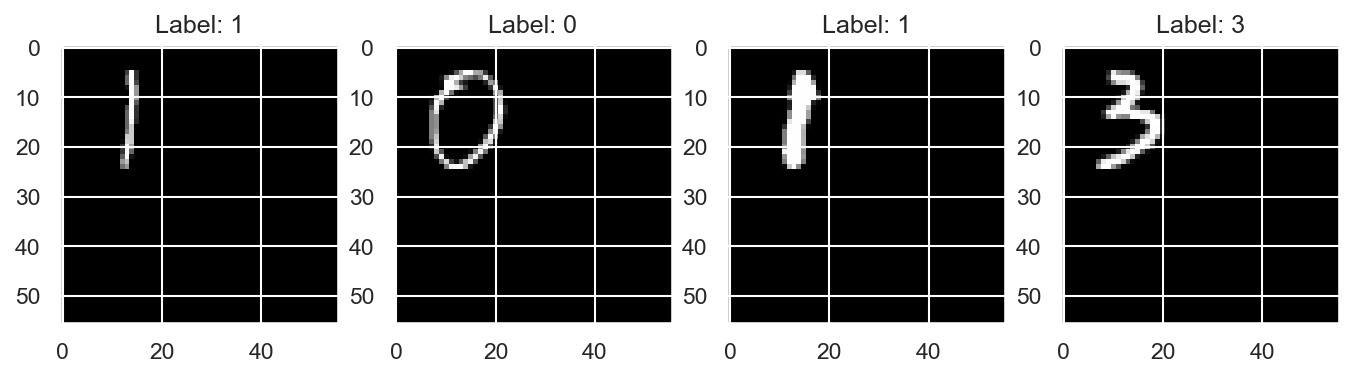

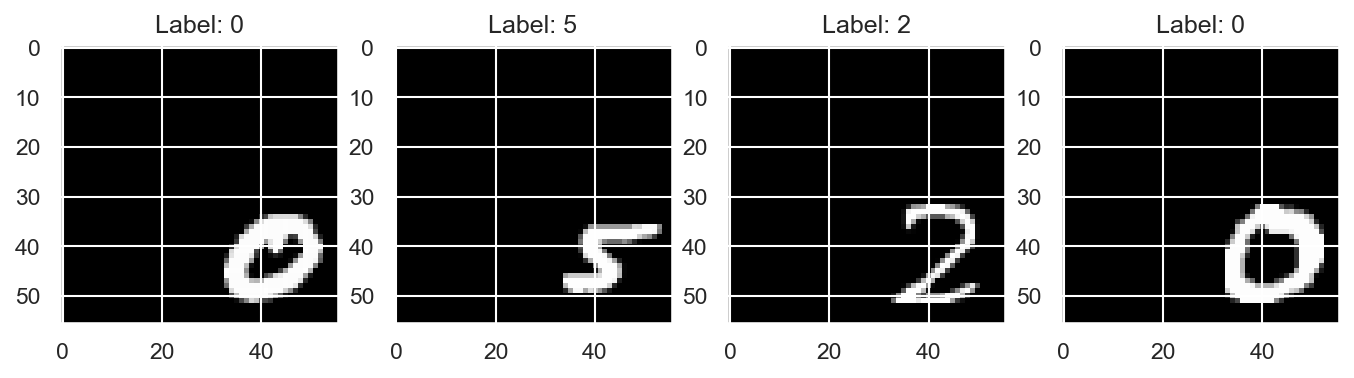

In [8]:
# TODO: Plot a few images from the test dataset

images, labels = next(iter(test_loader1))
kai.plot_images(images, labels)

images, labels = next(iter(test_loader2))
kai.plot_images(images, labels)

The images in the first test dataset are padded in exactly the same way as the training images (all digits are located in the top-left corner of the image). On this dataset, the model achieves a very high classification accuracy. In contrast, on the other test dataset, the accuracy of the model is very low at around 10% (as if the model was randomly guessing the digits, or it was always making the same prediction -- 1 out of 10 predictions is correct). 

The reason for this poor perfomance of the model is that the artificial neurons that process the pixels in the top-right, bottom-left, and bottom-right quadrants are never trained during the model development -- all digits in the training dataset are located in the top-left corner of the images. As a result, the network weights and biases in any other quadrant than the top-left corner do not influence the predictions of the model during training and their values remain random. Consequently, the model's classifications are meaningless for images where the digit is not located in the top-right corner.

In this case, this limitation of the training is easy to fix: we can simply complement the training dataset by images where the location of the digit is more variable. However, the need to supplement the training data raises a broader question about the "intelligence" of neural networks: how intelligent are MLPs really, if they cannot learn simple concepts, such as a digit, that they can use to make predictions beyond the training data? Afterall, we are looking to create artificial "intelligence" and not being able to classify the same digit just because it's located elsewhere in an image does not seem very intelligent...

Note, this inability to generalise beyond the training data is very much the same as the problem we faced with the Q&A neural network.

*Aside:* Just for completeness, we would like to stress that the challenge is not that MLPs are not capable of learning the correct classification function from the modified MNIST dataset. Neural networks are universal function approximators afterall. So the correct classification function is among the possible outcomes of the training. It is just extremely unlikely for the neural network to randomly approximate the function correctly for images that are not represented in the training dataset. This is because our objective function only measures the correctness of predictions and not that the model uses the right concepts to make those predictions. Below, we focus on ways how we can define neural networks differently to make generalisations easier, but working on how we can construct better objective functions for training is also a powerful way to improve the predictions of a neural network (see e.g. https://doi.org/10.1016/j.jcp.2018.10.045 and https://en.wikipedia.org/wiki/Physics-informed_neural_networks)

## 3 Inductive biases

One of the first approaches that tackled this lack of "concept learning" was developed by Yann Lecun, who is now a Computer Science professor at NYU and the Chief AI scientist at Meta. In his seminal paper, Lecun proposed to exploit prior knowledge about the task of image classification to make the neural network more efficient at learning from data and to help it generalise more easily beyond the training images (see https://hal.science/hal-03926082/document). More specifically, Lecun argued that image classification should not be sensitive to translations of the object of interest (i.e. the location of the digit in the image, see figure below). He therefore proposed the use of neural networks that are explicitly designed to make predictions which are invariant under these translations.

<img src="translation_invariance.gif" width="500" style="display: block; margin: 0 auto" >

His proposal to achieve this was to slighty modify how MLPs process images by introducing small blocks of artifical neurons that are slided across all patches of the image (see figure below). In this way, patterns learned in one region of the image can also be recognised in other regions of the image. These neural network layers are known as convolutional layers (in reference to functional analysis and physics, see https://en.wikipedia.org/wiki/Convolution).

<img src="convolution.gif" width="500" style="display: block; margin: 0 auto" >

Using convolutional layers, Lecun defined the first convolutional neural network (CNN) which was the first neural network that was able to learn something close to a concept of a digit in order to classify images correctly beyond the training dataset (see below). His network consisted of 2 convolutional layers, each followed by a pooling layer. We will work through these details below. Note that the final component of the network remains a MLP (see the final two "dense" layers in the figure). Dense layers are the layers that we have used before, where each input is processed by all artificial neurons. Dense layers are also sometimes referred to as fully connected layers. 

<img src="Lenet.svg" width="500" style="display: block; margin: 0 auto" >

Below we will implement Lecun's CNN, but before we do so, we just want to comment on the quite substantially more complex-looking architecture of the neural network in comparison to our "simple" MLPs that we used in the previous notebook. While Lecun's CNN looks complex at first, conceptually, its architecture is actually quite intuitive: it has one block that is responsible for feature extraction (the convolutional layers); and another block that is responsible for the classification (the dense layers). The feature extractor is based on prior knowledge of the image classification task and it implements inductive biases that help the neural network to learn more efficiently from data and to generalise more easily beyond the training data. The dense layers are not based on any prior assumptions about the modelling task and they simply make use of the universality of MLPs to map the extracted features to the probability masses of the digits. This combination of the universal function approximation theorem and inductive biases is one of the main reasons for the wide success of neural networks in recent years (including language processing).

### Task 7: Implement a convolutional layer

A convolutional layer processes inputs similar to the dense layers (``nn.Linear``) that we have used before, the only difference is that now a smaller number of artificial neurons is slided across the inputs, such that patterns learned from one patch of signals can also benefit the processing of another patch of signals. The neurons process the inputs as before by: 1. mutliplying the signals by model weights; 2. summing the weighted signals; 3. adding a bias; and 4. applying an activation function.

For images, this "patch processing" takes the form of sliding a small window of model weights across the image (see below). After multiplying the inputs by the weights, the values are summed up and a bias is added to produce the value for one patch of signals before applying the activation function. In the figure below, the bias is equal to 0.

<img src="convolutional_layer.gif" width="500" style="display: block; margin: 0 auto" >

Implement a convolutional layer that takes an image (two-dimensional array of shape (n, m)), the model weights (two-dimensional array of shape (k, k)) and the bias (float) as input, and it returns the processed image. For simplicity, we will choose a window of size 3x3 and assume that the input image is larger than 3x3 (just like in the image above).

In [30]:
# TODO: Complete the implementation
def convolutional_layer(inputs, weights, bias):
    inputs = np.array(inputs)
    m, n = inputs.shape
    if (m <= 3) or (n <= 3):
        raise ValueError('Inputs has the wrong shape.')
    weights = np.array(weights)
    k1, k2 = weights.shape
    if (k1 != 3) or (k2 != 3):
        raise ValueError('Weights has the wrong shape.')
    bias = float(bias)

    # TODO Implement the convolution
    output = np.empty(shape=(m-2, n-2))

    # Apply convolution
    for idm in range(m-2):
        for idn in range(n-2):
            output[idm, idn] = np.sum(inputs[idm:idm+3, idn:idn+3] * weights)

    # Add bias
    output += bias

    return output

In [39]:
# Test your implementation
# Test 1
inputs = np.array([
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0]
])
weights = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 1]
])
bias = 0
output = convolutional_layer(inputs, weights, bias)
true = np.array([
    [4, 3, 4],
    [2, 4, 3],
    [2, 3, 4]
])
np.testing.assert_equal(output, true)

# Test 2
bias = 5
output = convolutional_layer(inputs, weights, bias)
true = np.array([
    [9, 8, 9],
    [7, 9, 8],
    [7, 8, 9]
])
np.testing.assert_equal(output, true)

# Test 3
weights = np.array([
    [1, 0, 1],
    [0, 0, 0],
    [1, 0, 1]
])
output = convolutional_layer(inputs, weights, bias)
true = np.array([
    [8, 7, 8],
    [7, 8, 7],
    [7, 7, 8]
])
np.testing.assert_equal(output, true)


### Task 8: Discuss the purpose of a pooling layer

In Lecun's CNN each convolutional layer is followed by a pooling layer. A pooling layer aggregates neighbouring inputs into one output. This aggregation can take different forms. For example, the figure below shows a "max pooling" on the left and an "average pooling" on the right. For the max pooling, the output is the maximum value among the cluster of neighbouring pixels, while for the average pooling, the average value across the cluster of neighbouring pixels is returned.

<img src="average_pooling.gif" width="500" style="display: block; margin: 0 auto" >

Discuss in your group the purpose of pooling layers for the image classification task. Do they make features extracted by convolutional layers more robust? Are they simply a way of condensing the amount information that is being processed?